In [138]:
#Name: Luu Hoang Long Vo & Phu Hien Le
#UID: 23611 & 23607

In [139]:
!pip install pyspark

In [140]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import *

In [141]:
spark_application_name = "Spark_Application_Name"

In [142]:
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

# Preliminary

## Create helper function 

### `dfs_execution`

- Helper function to help execute a given functions on all dfs

In [143]:


def dfs_execution(list_df, list_name, func):
  list_exec_dfs = []
  for df, name in zip(list_df, list_name):
    print(name)
    list_exec_dfs.append(func(df))
    print('')
  return list_exec_dfs

### `read_disp_info`

- Helper function to help read and set the appropriate column to the given name and types
- Also print the schema of each df
- First 40 rows and last 40 rows are also displayed

In [144]:


def read_disp_info(file, delimiter = ',', header = True):
    
    devColumns = [StructField("Date",TimestampType()), StructField("High",FloatType()), StructField("Low",FloatType()), StructField("Open",FloatType()),StructField("Close",FloatType()),StructField("Volume",LongType()), StructField("Adj Close",FloatType()), StructField("company_name",StringType()) ]
    devSchema = StructType(devColumns)
    df = spark.read.options(header=header, delimiter=delimiter).csv(file, schema= devSchema)
    df.printSchema()
    print(df.head(40))
    print(df.tail(40))
    print(df.count())
    return df



# Finding the number of dates that separate between each other

In [145]:
def time_period(date_one, date_two):
    return date_two - date_one

# Describe each of the df by using `Dataframe.describe()`

In [146]:
def describe_df(df):
  df.describe().show(n=10)



# Count missing value (`NAs`, `Null`)

- Using aggregrate function `F.count()` with the given condition of checking missing value, create a new df containing the columns and the number of its missing value

In [147]:
import pyspark.sql.functions as F

def count_missing_alt(df):
  df = df.drop('Date')
  df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for c in df.columns]).show(n=10)

  


# Correlation

- Take the correlation between each columns once with the help of the function `Dataframe.corr()`

In [148]:
def correlation(df):
  df = df.drop('Date', 'company_name')
  columns = df.columns
  for i in range (len(columns)):
    for j in range (i+1, len(columns)):
      print(f"{columns[i]} & {columns[j]}: {str(df.corr(columns[i], columns[j]))}")




# Average opening and closing price:

- Given a `start_date` & an `end_date` 
    - Filter the rows within the given timeframe
    - Use aggregrate function `F.avg()` to extract the average of the desired column (`Open`, `Close`)
    - Check if it exist the average, if it exists then print it out to the output stream

In [149]:
def avg_opening_closing_prices(df, start_date, end_date):
    df = df.filter(F.col("Date").between(start_date, end_date))
    open_avg = df.select(F.avg('Open')).collect()
    close_avg = df.select(F.avg('Close')).collect()
    if (len(open_avg) == 1 and len(close_avg) == 1):
      if open_avg[0]['avg(Open)']:
        print(f"Open average price: {round(open_avg[0]['avg(Open)'], 2)}")
        print(f"Close average price: {round(close_avg[0]['avg(Close)'], 2)}")
      else:
        print("No data for existing company")

def avg_open_close_wrapper(df):
    avg_opening_closing_prices(df, '2017-01-03','2017-01-09')



#Stock price change

## Stock price day to day change

- Create a `Window` that is ordered by `Date`
- Loop through each of the columns that are in the `df`
- For each column creates a separate new column `prev_value` that represents the value of the column that is being looped but one day before
- Create the diff column by minus the original column and the `prev_value`
- Return a new `df` containing only the daily diff of each column

In [150]:
from pyspark.sql.window import Window

def stock_prices_day_to_day_change(df):
  my_window = Window.partitionBy().orderBy("Date")

  columns = ['High', 'Low', 'Open', 'Close', 'Adj Close']
  for col in columns:
    df = df.withColumn("prev_value", F.lag(df[col]).over(my_window))
    df = df.withColumn(f"{col} diff", F.when(F.isnull(df[col] - df.prev_value), 0)
                              .otherwise(df[col] - df.prev_value))
  df = df.drop(*columns, 'prev_value') 
  df.show(n=10)


## Stock price change monthly

- Extract all the distinct `years` and `months` from the dataframe
- Filter all the entries that exist within the given month and year
- Take the row containing the first day of the month of each month
- Find the difference between the two rows of two consecutive months to see the difference
- Store the difference in to a `monthly` dataframe

In [151]:

def stock_prices_delta_monthly(df):
    df = df.drop('Volume')
    years = df.select(F.year('Date')).distinct().collect()
    months = df.select(F.month('Date')).distinct().collect()
    lst = []
    for year in years:
        for month in months:
            lst.append(df.filter((F.year('Date') == year[0]) & (F.month('Date') == month[0])).collect())

    monthly_data = []
    for month in lst:
        if len(month) >= 1:
            monthly_data.append(month[0])
        
    monthly = spark.createDataFrame(monthly_data)
    
    my_window = Window.partitionBy().orderBy("Date")

    columns = ['High', 'Low', 'Open', 'Close', 'Adj Close']
    for col in columns:
        monthly = monthly.withColumn("prev_value", F.lag(monthly[col]).over(my_window))
        monthly = monthly.withColumn(f"{col} diff", F.when(F.isnull(monthly[col] - monthly.prev_value), 0)
                              .otherwise(monthly[col] - monthly.prev_value))
    
    monthly = monthly.drop(*columns, 'prev_value')
    monthly.show(n=10)    



# Daily Return
- Create a new column that contains the `daily_return` value that is named `Daily Return`
- Formula of `Daily Return` is `Opening Price - Closing Price = Daily Return`

In [152]:
def daily_return(df):
    df = df.withColumn("Daily Return", F.when(F.isnull(df['Open'] - df['Close']), 0)
                              .otherwise(df['Open'] - df['Close']))
    df.show(n=10)
    return df




# Highest Daily Return

- Combine all the existing stocks dataframes in to one big dataframe and then reindex the dataframe by `Date` column
- Extract all the unique dates exist in the dataframe
- For each of the date, extract the list of all the stocks that were traded on that date and select the one with the highest `daily_return` value
- Added the row with the highest value into a list and at the end create a new dataframe containing all highest `daily_return` for all dates

In [153]:
def highest_daily_return(list_df, n_days = None):
    total_stocks = None
    for df in list_df:
        if not total_stocks:
            total_stocks = df
        else:
            total_stocks = total_stocks.union(df)
    dates = total_stocks.select('Date').distinct().sort('Date').collect()
    print(len(dates))
    total_stocks = total_stocks.sort('Date')
    highest_daily_return = []
    for index, date in enumerate(dates):
        if n_days and index == n_days:
            break
        daily_return = total_stocks.select('Daily Return', 'company_name', 'Date').where(total_stocks['Date'] == date['Date'])
        w = Window.partitionBy('Date')
        highest_daily = daily_return.withColumn('maxDailyReturn', F.max('Daily Return').over(w))\
        .where(F.col('Daily Return') == F.col('maxDailyReturn'))\
        .drop('maxDailyReturn')\
        .collect()
        highest_daily_return += highest_daily
    
    return spark.createDataFrame(highest_daily_return)


# Average daily return for different period of time (weekly, monthly, yearly)

## Monthly average daily return

- Extract all the distinct `years` and `months` from the dataframe
- Filter all the entries that exist within the given month and year
- Deduce the average of that by the aggregrate function `F.avg()`
- Append the given row into a `lst`
- Create a dataframe at the end containing all the average `daily_return` of each month that exist in the `df`

In [154]:
def avg_daily_return_month(df):
    df = df.drop('High','Low','Open','Close','Volume','Adj Close','company_name')
    years = df.select(F.year('Date')).distinct().sort('Date').collect()
    months = df.select(F.month('Date')).distinct().sort('Date').collect()
    lst = []
    for year in years:
        for month in months:
            df_monthly = df.filter((F.year('Date') == year[0]) & (F.month('Date') == month[0]))
            lst.append(df_monthly.select(F.avg('Daily Return')).collect()[0])
    dates = []
    for year in years:
        for month in months:
            dates.append(f"{month[0]} - {year[0]}")
    monthly_return_avg_df = spark.createDataFrame(data=lst)
    monthly_return_avg_df = monthly_return_avg_df.repartition(1).withColumn("Month & Year", F.udf(lambda id: dates[id])(F.monotonically_increasing_id()))
    monthly_return_avg_df.show(n=10)
    

## Yearly average daily return
 
- Extract all the distinct `years` from the dataframe
- Filter all the entries that exist within the year
- Deduce the average of that by the aggregrate function `F.avg()`
- Append the given row into a `lst`
- Create a dataframe at the end containing all the average `daily_return` of each year that exist in the `df`

In [155]:
def avg_daily_return_year(df):
    df = df.drop('High','Low','Open','Close','Volume','Adj Close','company_name')
    years = df.select(F.year('Date')).distinct().sort('Date').collect()
    lst = []
    lst_dates = []
    for year in years:
          df_yearly = df.filter((F.year('Date') == year[0]))
          lst_dates.append(df_yearly.select(F.year('Date')).collect()[0])
          lst.append(df_yearly.select(F.avg('Daily Return')).collect()[0])

    dates = []
    for year in years:
        dates.append(year['year(Date)'])
    yearly_return_avg_df = spark.createDataFrame(data=lst)
    yearly_return_avg_df = yearly_return_avg_df.repartition(1).withColumn("Year", F.udf(lambda id: dates[id])(F.monotonically_increasing_id()))
    yearly_return_avg_df.show(n=10)

    

## Weekly average daily return

- Extract all the distinct `years` and `weeks` from the dataframe
- Filter all the entries that exist within the given week and year
- Deduce the average of that by the aggregrate function `F.avg()`
- Append the given row into a `lst`
- Create a dataframe at the end containing all the average `daily_return` of each week that exist in the `df`

In [156]:
def avg_daily_return_week(df):
    df = df.drop('High','Low','Open','Close','Volume','Adj Close','company_name')
    years = df.select(F.year('Date')).distinct().sort('Date').collect()
    weeks = df.select(F.weekofyear('Date')).distinct().sort(F.weekofyear('Date')).collect()
    lst = []
    dates = []
    for year in years:
        for week in weeks:
            df_weekly = df.filter((F.year('Date') == year[0]) & (F.weekofyear('Date') == week[0]))
            beginning_date = df_weekly.tail(1)
            if len(beginning_date) >= 1:
                lst.append(df_weekly.select(F.avg('Daily Return')).collect()[0])
                dates.append(beginning_date[0]['Date'].strftime('%d-%m-%Y'))
    weekly_return_avg_df = spark.createDataFrame(data=lst)
    weekly_return_avg_df = weekly_return_avg_df.repartition(1).withColumn("Week & Year", F.udf(lambda id: dates[id])(F.monotonically_increasing_id()))
    weekly_return_avg_df.show(n=10)
    


# Moving average

- Create a `Window` that takes the nearest `n` previous values 
- Using the aggregrate function `F.avg()` to find the average value over a certain number `n` previous datapoints
- Added the average to a new column `moving_average`

In [157]:
def moving_average(dataframe, column_name, n): 
    #df = dataframe.withColumn('Date', dataframe.timestampGMT.cast('timestamp'))
    w = Window.orderBy(dataframe["Date"].cast('long')).rangeBetween(-(n), 0)
    dataframe = dataframe.withColumn('moving_average', F.avg(column_name).over(w))
    dataframe.show(n=10)

def moving_average_wrapper(df):
  moving_average(df, 'Open', 5)



# Correlation between stocks
- Concatenate two given dataframes into one dataframe
- Use `corr` to calculate correlation between 2 columns of the 2 stocks, which is exactly 6 index apart in the new dataframe.

In [158]:
def concat_dfs(df1, df2):
    df_temp1 = df1.select('*')
    df_temp2 = df2.selectExpr("Date", "High as High2", "Low as Low2", "Open as Open2", "Close as Close2",  "Volume as Volume2", "`Adj Close` as AdjClose2")
    df_res = df_temp1.join(df_temp2, ["Date"]).drop("Date").drop("company_name")
    return df_res

def corr_dfs(df1, df2):
    df_concat = concat_dfs(df1, df2)
    columns = df_concat.columns
    for i in range(len(columns) // 2):
        print(columns[i] + " & "+ columns[i + 6] + " : " + str(df_concat.corr(columns[i], columns[i + 6])))

def corr_dfs_execution(list_df, list_name):
    for i in range(len(list_df)):
        for j in range(i+1, len(list_df)):
            print(f"\nCorrelation between {list_name[i]} & {list_name[j]}:")
            corr_dfs(list_df[i], list_df[j])


# Rate of return

## Rate of return given `start_date` and `end_date`

- Select the column and the `company_name` given the time frame
- Find the first and the last record of the filtered dataframe
- Apply the `rate of return` formula to the value `(last - first) / first`
- Return as a Tuple containing the `rate of return` and `company_name`

## Best rate of return given `start_date` and a Period dataclass

- `Period` class containing quantity of time to be added (`week, month, year`)
- Find the `end_date` from the given `Period` dataclass
- Loop through each column in the `df`:
    - Loop through each stock in the `list_df`:
        - Comparing the maximum `rate of return` using the `rate_of_return()` function 
    - Print out the maximum rate of return of a given period on each column



In [159]:
import datetime
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass

@dataclass
class Period:
    week: int = 0
    month: int = 0
    year: int = 0

def rate_of_return(df, start_date, end_date, col):
    time_range = df.select(df[col],df['company_name']).where(df.Date >= start_date).where(df.Date <= end_date)
    if (time_range.count() > 0):
        first_record = time_range.collect()[0]
        last_record = time_range.collect()[-1]
        rate_of_return = (last_record[col] - first_record[col])/first_record[col] * 100
        return (rate_of_return, first_record['company_name'])
    return (float("-inf"), 'No Company')

def best_rate_of_return(list_df, start_date, period: Period):
    cols = ['Open', 'Close', 'High', 'Low', 'Adj close']
    end_date = start_date + relativedelta(months=period.month, weeks=period.week, years=period.year)
    print(f"Period between {start_date} - {end_date}")
    for col in cols:
        maxi = (float("-inf"), 'No Company')
        for df in list_df:
            rate = rate_of_return(df, start_date, end_date, col)
            maxi = rate if max(maxi[0], rate[0]) == rate[0] else maxi
        print(f"Max rate of return on {col}: {maxi[0]} - {maxi[1]}")



In [160]:
def list_df_calculation():
    amazon_path = "stocks_data/AMAZON.csv"
    apple_path = "stocks_data/APPLE.csv"
    facebook_path = "stocks_data/FACEBOOK.csv"
    google_path = "stocks_data/GOOGLE.csv"
    microsoft_path = "stocks_data/MICROSOFT.csv"
    tesla_path = "stocks_data/TESLA.csv"
    zoom_path = "stocks_data/ZOOM.csv"
    print("EXPLORATION")
    print("Amazon: \n ---------")
    amazon = read_disp_info(amazon_path)
    print("Apple:  \n ---------")
    apple = read_disp_info(apple_path)
    print("Facebook:  \n ---------")
    facebook = read_disp_info(facebook_path)
    print("Google: \n ---------")
    google = read_disp_info(google_path)
    print("Microsoft: \n ---------")
    microsoft = read_disp_info(microsoft_path)
    print("Tesla: \n ---------")
    tesla = read_disp_info(tesla_path)
    print("Zoom: \n ---------")
    zoom = read_disp_info(zoom_path)
    return [amazon, apple, facebook, google, microsoft, tesla, zoom]
    
def main_output():
    list_df = list_df_calculation()
    list_name = ['amazon', 'apple', 'facebook', 'google', 'microsoft', 'tesla', 'zoom']
    print("DESCRIBING")
    dfs_execution(list_df, list_name, describe_df)
    print("COUNT MISSING")
    dfs_execution(list_df, list_name, count_missing_alt)
    print("CORRELATION")
    dfs_execution(list_df, list_name, correlation)
    print("AVERAGE OPENNING AND CLOSING")
    dfs_execution(list_df, list_name, avg_open_close_wrapper)
    print("STOCK PRICES DAY TO DAY CHANGE")
    dfs_execution(list_df, list_name, stock_prices_day_to_day_change)
    print("STOCK PRICES MONTH TO MONTH CHANGE")
    dfs_execution(list_df, list_name, stock_prices_delta_monthly)
    print("DAILY RETURN")
    list_exec_dfs = dfs_execution(list_df, list_name, daily_return)
    print("HIGHEST DAILY RETURN (25 days)")
    highest_daily_return_df = highest_daily_return(list_exec_dfs, 25)
    highest_daily_return_df.show(n=10)
    print("AVERAGE DAILY RETURN (YEAR)")
    dfs_execution(list_exec_dfs, list_name, avg_daily_return_year)
    print("AVERAGE DAILY RETURN (MONTH)")
    dfs_execution(list_exec_dfs, list_name, avg_daily_return_month)
    print("AVERAGE DAILY RETURN (WEEK)")
    dfs_execution(list_exec_dfs, list_name, avg_daily_return_week)
    print("MOVING AVERAGE (5 data points)")
    dfs_execution(list_df, list_name, moving_average_wrapper)
    print("CORRELATION BETWEEN DIFFERENT STOCKS")
    corr_dfs_execution(list_df, list_name)
    print('')
    print("RATE OF RETURN (AMAZON) FROM 03-01-2017 TO 21-01-2017")
    rate = rate_of_return(list_df[0], datetime.datetime(2017, 1, 3), datetime.datetime(2017, 1, 21), 'Open')
    print(rate)
    print("BEST RATE OF RETURN (ALL STOCKS) FROM 07-01-2017 TO A PERIOD OF 1 YEAR 4 WEEKS ")
    best_rate_of_return(list_df, datetime.datetime(2017, 1, 7), Period(year=1, month=0, week=4))

main_output()

EXPLORATION
Amazon: 
 ---------
root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: long (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

[Row(Date=datetime.datetime(2017, 1, 3, 0, 0), High=758.760009765625, Low=747.7000122070312, Open=757.9199829101562, Close=753.6699829101562, Volume=3521100, Adj Close=753.6699829101562, company_name='AMAZON'), Row(Date=datetime.datetime(2017, 1, 4, 0, 0), High=759.6799926757812, Low=754.2000122070312, Open=758.3900146484375, Close=757.1799926757812, Volume=2510500, Adj Close=757.1799926757812, company_name='AMAZON'), Row(Date=datetime.datetime(2017, 1, 5, 0, 0), High=782.4000244140625, Low=760.260009765625, Open=761.5499877929688, Close=780.4500122070312, Volume=5830100, Adj Close=780.4500122070312, company_name='AMAZON'), Row(Date=datetime.datetime(2017

#Insights


In [161]:
amazon_path = "stocks_data/AMAZON.csv"
apple_path = "stocks_data/APPLE.csv"
facebook_path = "stocks_data/FACEBOOK.csv"
google_path = "stocks_data/GOOGLE.csv"
microsoft_path = "stocks_data/MICROSOFT.csv"
tesla_path = "stocks_data/TESLA.csv"
zoom_path = "stocks_data/ZOOM.csv"
amazon = read_disp_info(amazon_path)
apple = read_disp_info(apple_path)
facebook = read_disp_info(facebook_path)
google = read_disp_info(google_path)
microsoft = read_disp_info(microsoft_path)
tesla = read_disp_info(tesla_path)
zoom = read_disp_info(zoom_path)
list_df = [amazon, apple, facebook, google, microsoft, tesla, zoom]
list_name = ['amazon', 'apple', 'facebook', 'google', 'microsoft', 'tesla', 'zoom']

root
 |-- Date: timestamp (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: long (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- company_name: string (nullable = true)

[Row(Date=datetime.datetime(2017, 1, 3, 0, 0), High=758.760009765625, Low=747.7000122070312, Open=757.9199829101562, Close=753.6699829101562, Volume=3521100, Adj Close=753.6699829101562, company_name='AMAZON'), Row(Date=datetime.datetime(2017, 1, 4, 0, 0), High=759.6799926757812, Low=754.2000122070312, Open=758.3900146484375, Close=757.1799926757812, Volume=2510500, Adj Close=757.1799926757812, company_name='AMAZON'), Row(Date=datetime.datetime(2017, 1, 5, 0, 0), High=782.4000244140625, Low=760.260009765625, Open=761.5499877929688, Close=780.4500122070312, Volume=5830100, Adj Close=780.4500122070312, company_name='AMAZON'), Row(Date=datetime.datetime(2017, 1, 6, 0, 0), High=799.44000244

#Bollinger Bands

- Bollinger bands are a type of technical indicator that allows traders to analyze the volatility of a stock and whether the price is high or low on a relative basis
- The top band is typically two standard deviations above the SMA and the bottom band is typically two standard deviations below the SMA (Simple Moving Average)
- Some quick observations you can make from looking at this graph is that the closing prices of the stock mostly stay in between both the Bollinger bands. In addition, you can identify buy signals when the price line hits the lower band and sell signals when the price line hits the higher band.

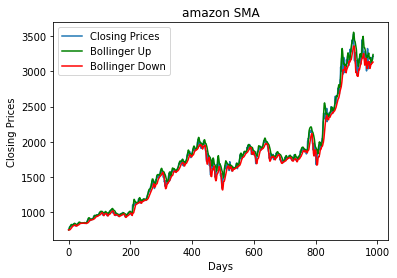

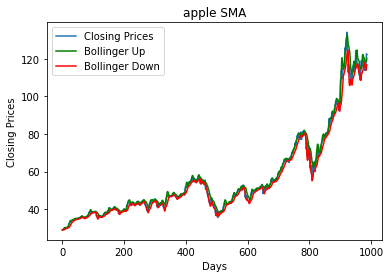

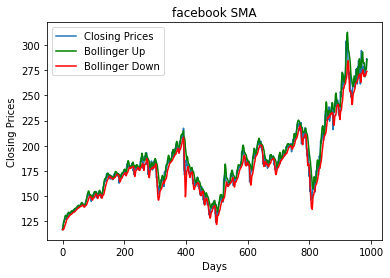

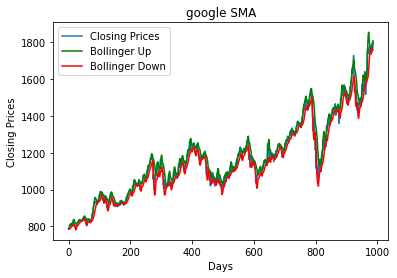

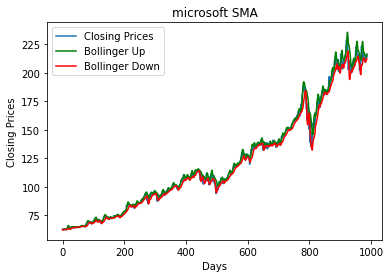

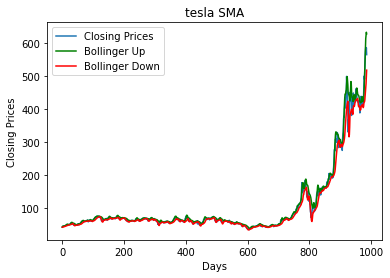

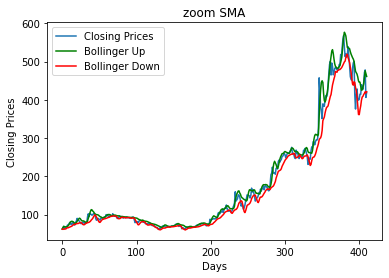

In [162]:
import matplotlib.pyplot as plt

def moving_average_std(dataframe, column_name, n): 
    w = Window.partitionBy().orderBy(F.col('Date')).rowsBetween(-5, 0)
    dataframe = dataframe.withColumn('moving_average', F.avg(column_name).over(w))
    dataframe = dataframe.withColumn('std', F.stddev('moving_average').over(w)) 
    return dataframe

def bollinger_calculate(df, column_name, n_days):
    return moving_average_std(df, column_name, 100)

def bollinger_bands_plot(df, name):
    closing_prices = df.select('Close').\
        rdd.flatMap(lambda x: x).collect()
    sma = df.select('moving_average').rdd.flatMap(lambda x: x).collect()
    std = df.select('std').rdd.flatMap(lambda x: x).collect()
    bollinger_up = []
    bollinger_down = []
    for avg, dev in zip(sma, std):
        dev = 0 if not dev else dev
        bollinger_up.append(avg + dev * 2)
        bollinger_down.append(avg - dev * 2)
    
    plt.title(name + ' SMA')
    plt.xlabel('Days')
    plt.ylabel('Closing Prices')
    plt.plot(closing_prices, label='Closing Prices')
    plt.plot(bollinger_up, label='Bollinger Up', c='g')
    plt.plot(bollinger_down, label='Bollinger Down', c='r')
    plt.legend()
    plt.show()

def plot_all_bollinger_bands(list_df, list_name, column_name, n_days = 20):
    for df, name in zip(list_df, list_name):
        df_bollinger = bollinger_calculate(df, column_name, n_days)
        bollinger_bands_plot(df_bollinger, name) 


plot_all_bollinger_bands(list_df, list_name, 'Close')

#Evolution of stocks open prices

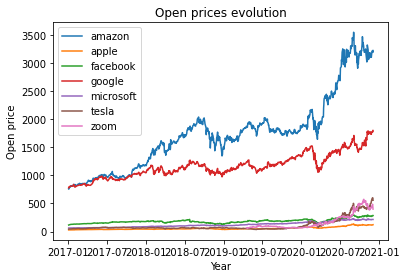

In [163]:
import matplotlib.pyplot as plt

def evolution_stock(list_df, list_name, column_name):
    for df, name in zip(list_df, list_name):
        dates = df.select('Date').rdd.flatMap(lambda x: x).collect()
        prices = df.select(column_name).rdd.flatMap(lambda x: x).collect()
        plt.plot(dates, prices, label=name)
    
    plt.title('Open prices evolution')
    plt.xlabel('Year')
    plt.ylabel(f'{column_name} price')
    plt.legend()
    plt.show()
    
evolution_stock(list_df, list_name, 'Open')

#Moving Average Convergence Divergence
Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.MACD is calculated by subtracting the long-term EMA (26 periods) from the short-term EMA (12 periods). The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the security when the MACD crosses above its signal line and sell—or short—the security when the MACD crosses below the signal line.

#Diversification
Diversification is a risk management strategy that mixes a wide variety of investments within a portfolio. A diversified portfolio contains a mix of distinct asset types and investment vehicles in an attempt at limiting exposure to any single asset or risk. The rationale behind this technique is that a portfolio constructed of different kinds of assets will, on average, yield higher long-term returns and lower the risk of any individual holding or security. 

#Value at Risk
Value at risk (VaR) is a statistic that quantifies the extent of possible financial losses within a firm, portfolio, or position over a specific time frame. This metric is most commonly used by investment and commercial banks to determine the extent and probabilities of potential losses in their institutional portfolios.

Risk managers use VaR to measure and control the level of risk exposure. One can apply VaR calculations to specific positions or whole portfolios or use them to measure firm-wide risk exposure. 

#Aroon Oscillator
The Aroon Oscillator is a trend-following indicator that uses aspects of the Aroon Indicator (Aroon Up and Aroon Down) to gauge the strength of a current trend and the likelihood that it will continue. The highs and lows used in the Aroon Up and Aroon Down calculations help to create an inverse relationship between the two indicators. When the Aroon Up value increases, the Aroon Down value will typically see a decrease and vice versa.

When Aroon Up remains high from consecutive new highs, the oscillator value will be high, following the uptrend. When a security’s price is on a downtrend with many new lows, the Aroon Down value will be higher resulting in a lower oscillator value. 